In [8]:
import datasets
from langchain.docstore.document import Document

# 加载数据集
guest_dataset = datasets.load_dataset("agents-course/unit3-invitees", split="train")

# 转换为 Document 对象
docs = [
    Document(
        page_content="\n".join([
            f"Name: {guest['name']}",
            f"Relation: {guest['relation']}",
            f"Description: {guest['description']}",
            f"Email: {guest['email']}"
        ]),
        metadata={"name": guest["name"]}
    )
    for guest in guest_dataset
]

In [9]:
from langchain_community.retrievers import BM25Retriever
from langchain.tools import Tool

bm25_retriever = BM25Retriever.from_documents(docs)

def extract_text(query: str) -> str:
    """Retrieves detailed information about gala guests based on their name or relation."""
    results = bm25_retriever.invoke(query)
    if results:
        return "\n\n".join([doc.page_content for doc in results[:3]])
    else:
        return "No matching guest information found."

guest_info_tool = Tool(
    name="guest_info_retriever",
    func=extract_text,
    description="Retrieves detailed information about gala guests based on their name or relation."
)

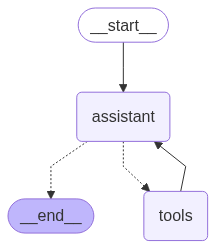

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

# 生成聊天界面，包括工具
chat = ChatOpenAI(
        model="deepseek-chat",
        openai_api_key="",  # 替换为您的DeepSeek API密钥
        openai_api_base="https://api.deepseek.com/v1",
        verbose=True
    )
    
tools = [guest_info_tool]
chat_with_tools = chat.bind_tools(tools)

# 生成 AgentState 和 Agent 图
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## 构建流程图
builder = StateGraph(AgentState)

# 定义节点：这些节点完成工作
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 定义边：这些决定了控制流如何移动
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

display(Image(alfred.get_graph().draw_mermaid_png()))

In [32]:
# 重新初始化Alfred代理
messages = [
    HumanMessage(content="Tell me about our guest named 'Lady Ada Lovelace'.")
]
response = alfred.invoke({"messages": messages})
print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
Here's the information about our guest, Lady Ada Lovelace:

- **Name:** Ada Lovelace  
- **Relation:** Best friend  
- **Description:** Lady Ada Lovelace is an esteemed mathematician and a close friend. She is renowned for her pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work on Charles Babbage's Analytical Engine.  
- **Email:** ada.lovelace@example.com  

Let me know if you'd like to connect with her or need any further details!


In [33]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()
results = search_tool.invoke("Who's the current President of France?")
print(results)

Emmanuel Macron (born December 21, 1977, Amiens, France) is a French banker and politician who was elected president of France in 2017. Macron was the first person in the history of the Fifth Republic to win the presidency without the backing of either the Socialists or the Gaullists, and he was France's youngest head of state since Napoleon I.He was reelected in 2022, becoming the first ... Welcome to the official website of the President of France The President's latest news All news 19 May 2025 8th Edition of the Choose France Summit. 22 June 2025 E3 leaders' declaration on the situation in the Middle East. 17 June 2025 G7 Leaders' Statement ... France, one of the world's most influential nations, is led by a head of state with significant domestic and international responsibilities. As of 2025, the President of France is Emmanuel Macron, a centrist leader known for his ambitious reforms, pro-European stance, and distinctive personality. This article explores who Emmanuel Macron is 

In [34]:
from langchain.tools import Tool
import random

def get_weather_info(location: str) -> str:
    """Fetches dummy weather information for a given location."""
    # 虚拟天气数据
    weather_conditions = [
        {"condition": "Rainy", "temp_c": 15},
        {"condition": "Clear", "temp_c": 25},
        {"condition": "Windy", "temp_c": 20}
    ]
    # 随机选择一种天气状况
    data = random.choice(weather_conditions)
    return f"Weather in {location}: {data['condition']}, {data['temp_c']}°C"

# 初始化工具
weather_info_tool = Tool(
    name="get_weather_info",
    func=get_weather_info,
    description="Fetches dummy weather information for a given location."
)

In [36]:
from langchain.tools import Tool
from huggingface_hub import list_models

def get_hub_stats(author: str) -> str:
    """Fetches the most downloaded model from a specific author on the Hugging Face Hub."""
    try:
        # 列出指定作者的模型，按下载次数排序
        models = list(list_models(author=author, sort="downloads", direction=-1, limit=1))

        if models:
            model = models[0]
            return f"The most downloaded model by {author} is {model.id} with {model.downloads:,} downloads."
        else:
            return f"No models found for author {author}."
    except Exception as e:
        return f"Error fetching models for {author}: {str(e)}"

# 初始化工具
hub_stats_tool = Tool(
    name="get_hub_stats",
    func=get_hub_stats,
    description="Fetches the most downloaded model from a specific author on the Hugging Face Hub."
)

# 示例用法
print(hub_stats_tool("facebook")) # Example: Get the most downloaded model by Facebook

The most downloaded model by facebook is facebook/opt-125m with 4,759,379 downloads.


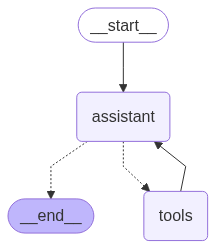

In [38]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# 生成聊天界面，包括工具
chat = ChatOpenAI(
        model="deepseek-chat",
        openai_api_key="sk-e5965c4427e647e080f38e4fc50d95e0",  # 替换为您的DeepSeek API密钥
        openai_api_base="https://api.deepseek.com/v1",
        verbose=True
    )
    
tools = [search_tool, weather_info_tool, hub_stats_tool]
chat_with_tools = chat.bind_tools(tools)

# 生成 AgentState 和 Agent 图
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## 构建流程图
builder = StateGraph(AgentState)

# 定义节点：这些节点完成工作
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 定义边：这些决定了控制流如何移动
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

display(Image(alfred.get_graph().draw_mermaid_png()))

In [40]:
messages = [HumanMessage(content="Who is Facebook and what's their most popular model?")]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
Facebook, now known as Meta, is a multinational technology company founded by Mark Zuckerberg in 2004. It is best known for its social media platform, Facebook, but the company also owns other popular platforms like Instagram, WhatsApp, and Oculus. Meta is heavily involved in artificial intelligence (AI) research and development, particularly in areas like natural language processing (NLP), computer vision, and virtual reality.

One of Meta's most popular AI models is **Llama (Large Language Model Meta AI)**. The latest version, **Llama 2**, was released in 2023 and is an open-source large language model designed for a variety of applications, including chatbots, content generation, and more. Llama 2 has gained significant attention for its performance and accessibility, as it is available for both research and commercial use.

Would you like more details about Llama 2 or Meta's other AI initiatives?


In [42]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

from tools import DuckDuckGoSearchRun, weather_info_tool, hub_stats_tool
from retriever import guest_info_tool

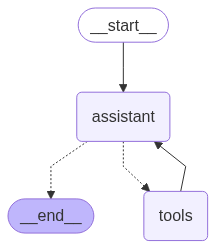

In [45]:
# 初始化网络搜索工具
search_tool = DuckDuckGoSearchRun()

# 生成包含工具的聊天接口
chat = ChatOpenAI(
        model="deepseek-chat",
        openai_api_key="sk-e5965c4427e647e080f38e4fc50d95e0",  # 替换为您的DeepSeek API密钥
        openai_api_base="https://api.deepseek.com/v1",
        verbose=True
    )

tools = [guest_info_tool, search_tool, weather_info_tool, hub_stats_tool]
chat_with_tools = chat.bind_tools(tools)

# 生成 AgentState 和 Agent 图
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

##  构建流程图
builder = StateGraph(AgentState)

# 定义节点：执行具体工作
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 定义边：控制流程走向
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # 如果最新消息需要工具调用，则路由到 tools 节点
    # 否则直接响应
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()
display(Image(alfred.get_graph().draw_mermaid_png()))

In [48]:
response = alfred.invoke({"messages": "Tell me about 'Lady Ada Lovelace'"})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
Ada Lovelace, born Augusta Ada Byron on December 10, 1815, was an English mathematician and writer, often celebrated as the world's first computer programmer. She was the daughter of the famous poet Lord Byron and mathematician Annabella Milbanke. Her parents' marriage was tumultuous, and her mother encouraged her interest in mathematics and logic to steer her away from her father's perceived erratic behavior.

### Key Contributions:
1. **Collaboration with Charles Babbage**: Ada Lovelace worked closely with Charles Babbage, the inventor of the Analytical Engine, a mechanical general-purpose computer. She translated an article about the engine and added extensive notes, including an algorithm designed to be processed by the machine. This is considered the first published algorithm intended for a computer, earning her the title of the first computer programmer.

2. **Visionary Insights**: Lovelace foresaw the potential of computers beyond mere calculation, suggestin

In [49]:
response = alfred.invoke({"messages": "What's the weather like in Paris tonight? Will it be suitable for our fireworks display?"})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
The weather in Paris tonight is windy with a temperature of 20°C. 

For a fireworks display, wind can be a concern as it may affect the trajectory and visibility of the fireworks. You may want to check the wind speed and direction to ensure it's safe and suitable for the display. Would you like me to find more specific details about the wind conditions?


In [50]:
response = alfred.invoke({"messages": "One of our guests is from Qwen. What can you tell me about their most popular model?"})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
The most popular model by Qwen is **Qwen/Qwen2-7B-Instruct**, which has been downloaded **9,713,862 times**. Let me know if you'd like more details about this model or anything else!


In [51]:
response = alfred.invoke({"messages":"I need to speak with 'Dr. Nikola Tesla' about recent advancements in wireless energy. Can you help me prepare for this conversation?"})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
Dr. Nikola Tesla is an old friend from your university days who has recently patented a new wireless energy transmission system. He would be delighted to discuss this with you. Here are some key points to prepare for your conversation:

### Topics to Discuss:
1. **Wireless Energy Transmission System**:
   - Ask about the specifics of his new patent.
   - Inquire about how it differs from existing technologies.
   - Discuss potential applications and scalability.

2. **Recent Advancements**:
   - Ask about any breakthroughs or challenges he has encountered.
   - Discuss the future of wireless energy and its impact on society.

3. **Personal Touch**:
   - Mention his passion for pigeons as an icebreaker. For example, "How are your pigeons doing these days?"

### Contact Information:
- **Email**: nikola.tesla@gmail.com  
  You can reach out to him directly to set up a meeting or continue the conversation.

Would you like me to draft an email for you to send to Dr. Tes

In [58]:
# 首次交互
response = alfred.invoke({"messages": [HumanMessage(content="Tell me about 'Lady Ada Lovelace'. What's her background and how is she related to me?")]})


print("🎩 Alfred's Response:")
print(response['messages'][-1].content)
print()

# 二次交互（引用首次内容）
response = alfred.invoke({"messages": response["messages"] + [HumanMessage(content="What projects is she currently working on?")]})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
### About Lady Ada Lovelace

**Background:**
Ada Lovelace, born Augusta Ada Byron on December 10, 1815, was an English mathematician and writer. She is best known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine. Ada was the first to recognize that the machine had applications beyond pure calculation, and she wrote what is considered the first algorithm intended to be processed by a machine. This earned her the title of the "first computer programmer."

Her father was the famous poet Lord Byron, but Ada was raised by her mother, Lady Anne Isabella Milbanke, after her parents separated. Despite a challenging childhood, Ada developed a keen interest in mathematics and science, which was encouraged by her tutors. She collaborated closely with Charles Babbage and became a visionary in the field of computing, foreseeing the potential of computers long before they became a reality.

Ada Lovelace passed away on November

In [59]:
response["messages"] 

[HumanMessage(content="Tell me about 'Lady Ada Lovelace'. What's her background and how is she related to me?", additional_kwargs={}, response_metadata={}, id='a8855b99-50a9-4554-b081-4c5195f47bd6'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_00a0115a-26f7-43c8-9440-f1493e1ffc4a', 'function': {'arguments': '{"query": "Lady Ada Lovelace background"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}, {'id': 'call_1_4d1a7c39-f665-454e-8811-a324c16cf465', 'function': {'arguments': '{"__arg1":"Lady Ada Lovelace"}', 'name': 'guest_info_retriever'}, 'type': 'function', 'index': 1}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 466, 'total_tokens': 521, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 448}, 'prompt_cache_hit_tokens': 448, 'prompt_cache_miss_tokens': 18}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_k